# Factor trading - Q-Learning

Optimise the return of the portfolio through the value function Q from the input of the factor database

NEED TO IMPLEMENT THE REWARD FUNCTION and the Value function 

## 1. load the libraries and constants

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

SOURCE_FOLDER = 'Data-processed'
FACTOR_FOLDER = 'Data-factor'
TARGET_FOLDER = "Output"

DESCRIPTION_FILE = "data_list.csv"
DATA_FILE = "data_content.csv"
RISK_FILE = "data_risk.csv"
FACTOR_FILE = "data_factor.csv"

INVESTMENT = 10000

## 2. load the data

In [3]:
# Load the time-series dataset, the static dataset and the risk dataset. 
df_desc = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DESCRIPTION_FILE),encoding='utf-8',index_col=0)
df_data = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DATA_FILE),encoding='utf-8', index_col=0)
df_risk = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, RISK_FILE),encoding='utf-8', index_col=0)
# Load the factor dataset
df_factor = pd.read_csv(os.path.join(os.getcwd(),FACTOR_FOLDER, FACTOR_FILE),encoding='utf-8', index_col=0)

## 3. Factor trading

In [4]:
from collections import deque
import random

#df= df_full.copy()
name = 'Q-learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [5]:
#close = df.Close.values.tolist()
close = df_data["-".join(['US22160K1051',"P"])].dropna().values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 20, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
epoch: 10, total rewards: 7929.038600.3, cost: 0.187183, total money: 1290.278800
epoch: 20, total rewards: 6830.295600.3, cost: 0.111305, total money: 1637.396100


In [6]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 8: buy 1 unit at price 37.040000, total balance 9962.960000
day 9, sell 1 unit at price 37.070000, investment 0.080994 %, total balance 10000.030000,
day 10: buy 1 unit at price 37.070000, total balance 9962.960000
day 11, sell 1 unit at price 36.400000, investment -1.807391 %, total balance 9999.360000,
day 19: buy 1 unit at price 36.940000, total balance 9962.420000
day 20: buy 1 unit at price 37.220000, total balance 9925.200000
day 22, sell 1 unit at price 37.300000, investment 0.974553 %, total balance 9962.500000,
day 23, sell 1 unit at price 37.920000, investment 1.880709 %, total balance 10000.420000,
day 28: buy 1 unit at price 37.750000, total balance 9962.670000
day 30: buy 1 unit at price 37.760000, total balance 9924.910000
day 31, sell 1 unit at price 37.830000, investment 0.211921 %, total balance 9962.740000,
day 33, sell 1 unit at price 38.180000, investment 1.112288 %, total balance 10000.920000,
day 35: buy 1 unit at price 38.450000, total balance 9962.470000
day

day 642, sell 1 unit at price 52.560000, investment -2.882483 %, total balance 9231.399900,
day 643: buy 1 unit at price 53.360000, total balance 9178.039900
day 644, sell 1 unit at price 54.000000, investment -4.761905 %, total balance 9232.039900,
day 645, sell 1 unit at price 53.330000, investment -5.794029 %, total balance 9285.369900,
day 646, sell 1 unit at price 51.450000, investment -9.419014 %, total balance 9336.819900,
day 647, sell 1 unit at price 51.870000, investment -7.474135 %, total balance 9388.689900,
day 648: buy 1 unit at price 52.760000, total balance 9335.929900
day 649: buy 1 unit at price 52.250000, total balance 9283.679900
day 650: buy 1 unit at price 52.440000, total balance 9231.239900
day 651, sell 1 unit at price 51.000000, investment -7.658881 %, total balance 9282.239900,
day 652: buy 1 unit at price 51.780000, total balance 9230.459900
day 653, sell 1 unit at price 51.470000, investment -4.348634 %, total balance 9281.929900,
day 654: buy 1 unit at pri

day 1204, sell 1 unit at price 58.410000, investment -8.620150 %, total balance 6355.950100,
day 1205: buy 1 unit at price 53.610000, total balance 6302.340100
day 1206: buy 1 unit at price 57.790000, total balance 6244.550100
day 1208: buy 1 unit at price 58.080000, total balance 6186.470100
day 1211: buy 1 unit at price 52.210000, total balance 6134.260100
day 1212: buy 1 unit at price 50.930000, total balance 6083.330100
day 1214, sell 1 unit at price 57.480000, investment -11.528398 %, total balance 6140.810100,
day 1216: buy 1 unit at price 56.970000, total balance 6083.840100
day 1217: buy 1 unit at price 57.010000, total balance 6026.830100
day 1218: buy 1 unit at price 53.470000, total balance 5973.360100
day 1219: buy 1 unit at price 55.090000, total balance 5918.270100
day 1220: buy 1 unit at price 53.710000, total balance 5864.560100
day 1224: buy 1 unit at price 52.280000, total balance 5812.280100
day 1228: buy 1 unit at price 47.310000, total balance 5764.970100
day 1231:

day 1845: buy 1 unit at price 81.040000, total balance 3867.427600
day 1846: buy 1 unit at price 80.510000, total balance 3786.917600
day 1849, sell 1 unit at price 80.450000, investment 37.006131 %, total balance 3867.367600,
day 1851, sell 1 unit at price 82.230000, investment 39.870726 %, total balance 3949.597600,
day 1854: buy 1 unit at price 82.720000, total balance 3866.877600
day 1855, sell 1 unit at price 82.310000, investment 39.626802 %, total balance 3949.187600,
day 1859: buy 1 unit at price 83.400000, total balance 3865.787600
day 1860, sell 1 unit at price 82.640000, investment 44.097646 %, total balance 3948.427600,
day 1862, sell 1 unit at price 80.320000, investment 39.857217 %, total balance 4028.747600,
day 1863, sell 1 unit at price 80.810000, investment 39.544120 %, total balance 4109.557600,
day 1864, sell 1 unit at price 81.530000, investment 39.177194 %, total balance 4191.087600,
day 1869, sell 1 unit at price 77.690000, investment 32.215793 %, total balance 4

day 2486, sell 1 unit at price 124.290000, investment 35.895473 %, total balance 923.025500,
day 2487: buy 1 unit at price 123.310000, total balance 799.715500
day 2489: buy 1 unit at price 122.760000, total balance 676.955500
day 2490, sell 1 unit at price 123.890000, investment 36.985847 %, total balance 800.845500,
day 2492, sell 1 unit at price 125.170000, investment 38.677155 %, total balance 926.015500,
day 2495: buy 1 unit at price 125.430000, total balance 800.585500
day 2496: buy 1 unit at price 123.690000, total balance 676.895500
day 2498, sell 1 unit at price 122.970000, investment 35.668579 %, total balance 799.865500,
day 2499: buy 1 unit at price 120.950000, total balance 678.915500
day 2501, sell 1 unit at price 121.660000, investment 40.940686 %, total balance 800.575500,
day 2503, sell 1 unit at price 118.570000, investment 35.245808 %, total balance 919.145500,
day 2504, sell 1 unit at price 118.220000, investment 35.449129 %, total balance 1037.365500,
day 2505, sel

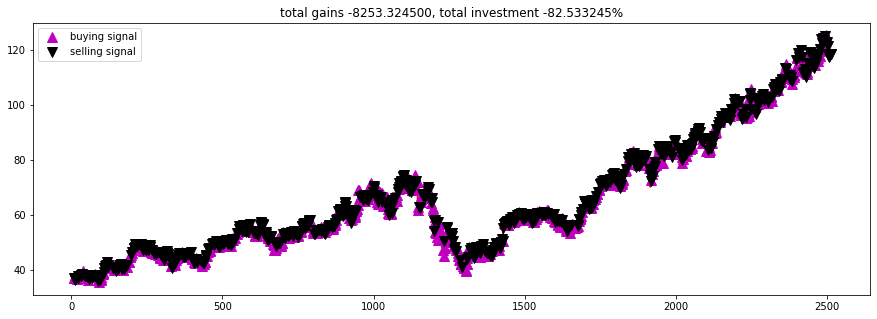

In [7]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()